---
# Sustained Radiation Events (SREs) - Sea-Level Pressure Analysis
---
This notebook investigate on a local scale the relationship between SREs and sea-level pressure (SLP).

The data used in this notebook are from CMIP6 Climate models.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import pickle
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns

matplotlib.rcParams.update({'font.size': 26})

---
## Loading Data and Computing L-day means

In [2]:
locations      = ['Zurich', 'London', 'Madrid', 'Moscow'] # Choose locations of interest
model_name     = 'GFDL-ESM4'                              # Choose model of interest      
percentiles    = [10, 90]                                 # Choose percentiles of interest
variable_names = ['rsds', 'psl']                          # Our two CMIP6 variables of interest ('rsds' = SSR, 'psl' = pressure sea-level)

time_series_dict  = {location: {} for location in locations}

n_years = 500 # Length of the GFDL-ESM4 piControl in years

seasons, masks   = my_functions.get_seasons_masks(n_years) # Load the season masks

for location in locations:

    #### Sea-Level Pressure
    time_series_models = pickle.load(open(f'Data/psl/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py
    time_series        = time_series_models[model_name]
    time_series        = time_series/100                                                     # Change units from Pa to hPa

    psl_reshaped   = my_functions.reshape(time_series) # Reshape our time series into n_years x 365
    psl_daily_mean = np.mean(psl_reshaped, axis = 0)   # Compute the mean for each calendar day
    psl_daily_std  = np.std(psl_reshaped, axis = 0)    # Compute the std for each calendar day

    psl_anomalies            = time_series - np.tile(psl_daily_mean, 500) # Get the slp anomalies wrt daily mean
    psl_anomalies_normalized = psl_anomalies/np.tile(psl_daily_std, 500)  # Get the normalised slp anomalies

    time_series_dict[location]['psl']           = time_series
    time_series_dict[location]['psl_anomalies'] = psl_anomalies_normalized

    #### Surface Solar Radiation 
    time_series_models = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py
    time_series        = time_series_models[model_name]                          # Get data only for model_name
    SREs_output        = my_functions.compute_SREs(time_series=time_series, percentiles=percentiles)  # type: ignore # Compute SREs 

    time_series_dict[location]['rsds'] = time_series  

    #### Compute L-day means

    # Create subdictionnaries for the L-day means for each percentiles
    time_series_dict[location]['rsds_waves_mean'] = {} 
    time_series_dict[location]['psl_waves_mean']  = {}
    
    for percentile in percentiles:
        
        rsds_all_years_above_percentile = SREs_output[percentile]['rsds_all_years_above']
        SREs_all_years                  = SREs_output[percentile]['SREs_all_years']
        indices = np.where(SREs_all_years < 3)[0] # Get all days without a SREs of 3 or more consecutive days

        psl_anomalies_waves = time_series_dict[location]['psl_anomalies'] * rsds_all_years_above_percentile
        rsds_waves          = time_series_dict[location]['rsds']          * rsds_all_years_above_percentile

        time_series_dict[location]['psl_waves_mean'][percentile]  = my_functions.compute_group_means_and_replace(psl_anomalies_waves)
        time_series_dict[location]['rsds_waves_mean'][percentile] = my_functions.compute_group_means_and_replace(rsds_waves)
        time_series_dict[location]['psl_waves_mean'][percentile][indices]  = np.nan
        time_series_dict[location]['rsds_waves_mean'][percentile][indices] = np.nan

SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 500 years (182500 days)

Percentiles considered: [10, 90]

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (182500,): give the daily thresholds for all simulation days
          - rsds_all_years_above (182500,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (182500,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.


SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 500 years (182500 days)

Percentiles considered: [10, 90]

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (182500,): give the daily thresholds for all simulation days
          - rsds_all_years_above (182500,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (182500,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.
SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 500 years (182500 days)

Percentiles considered: [10, 90]

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs 

---
## Results Visualisation

We are showing for all locations and each percentile the L-day mean SSR vs. mean SLP normalised anomalies.

location = 'Zurich' and percentile = 10


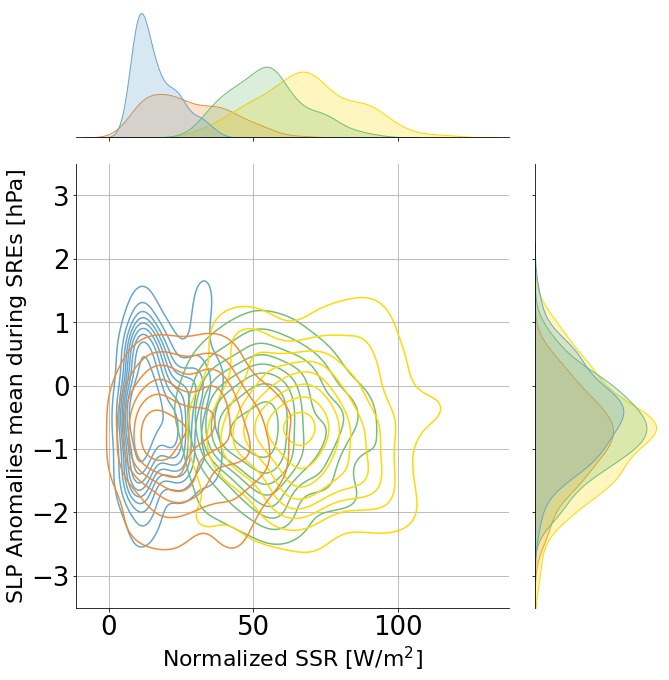

location = 'Zurich' and percentile = 90


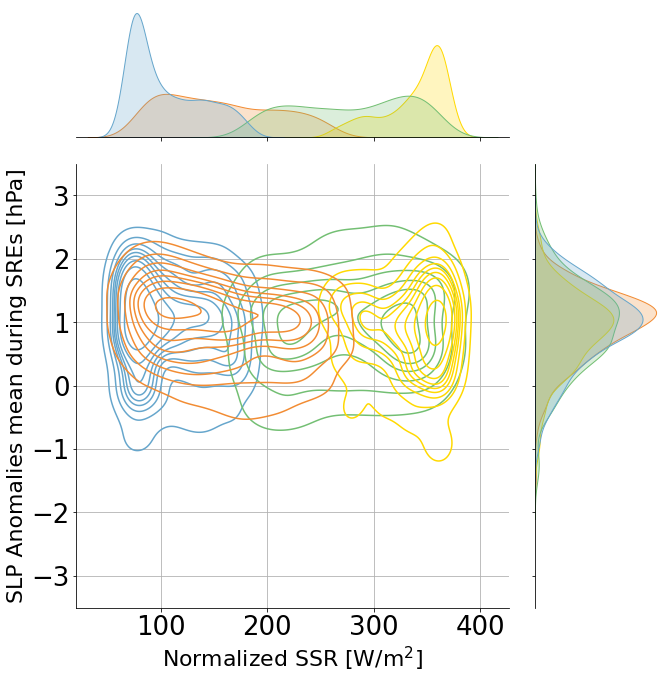

location = 'London' and percentile = 10


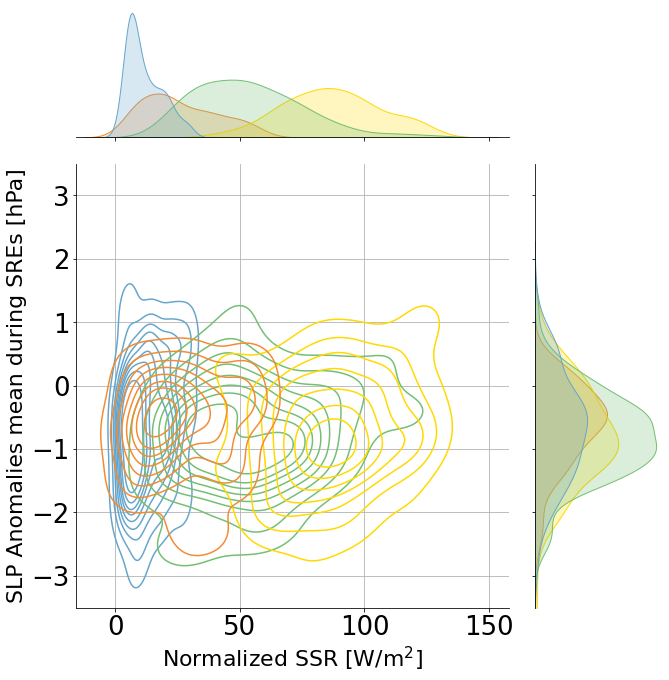

location = 'London' and percentile = 90


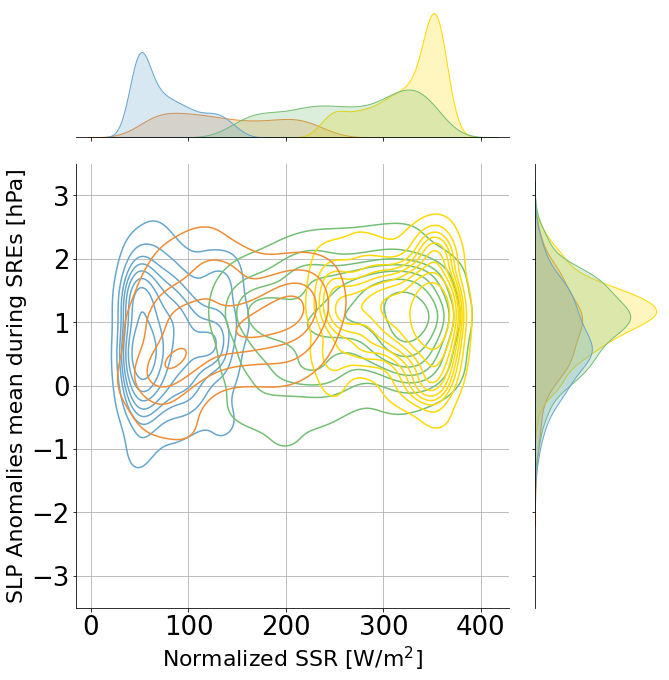

location = 'Madrid' and percentile = 10


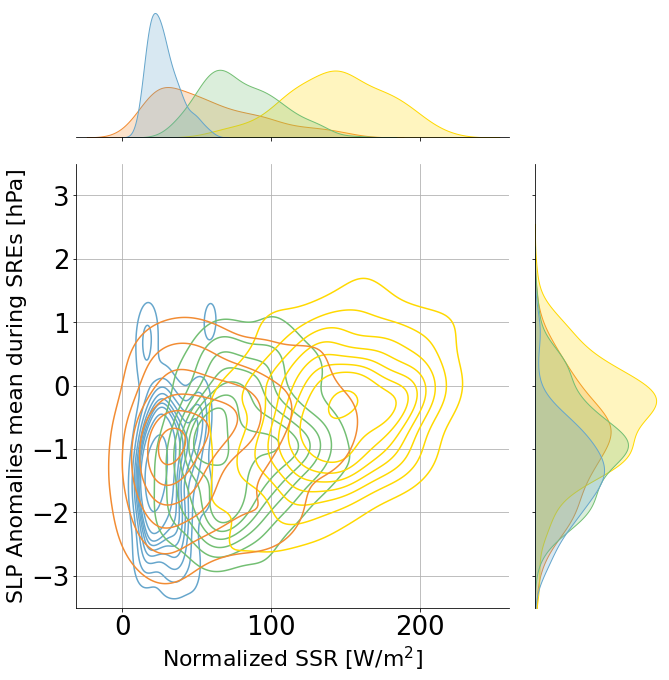

location = 'Madrid' and percentile = 90


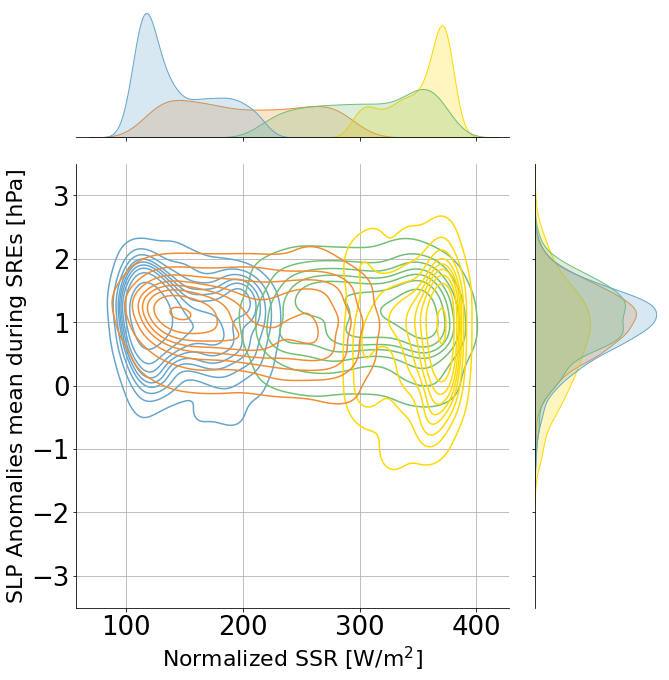

location = 'Moscow' and percentile = 10


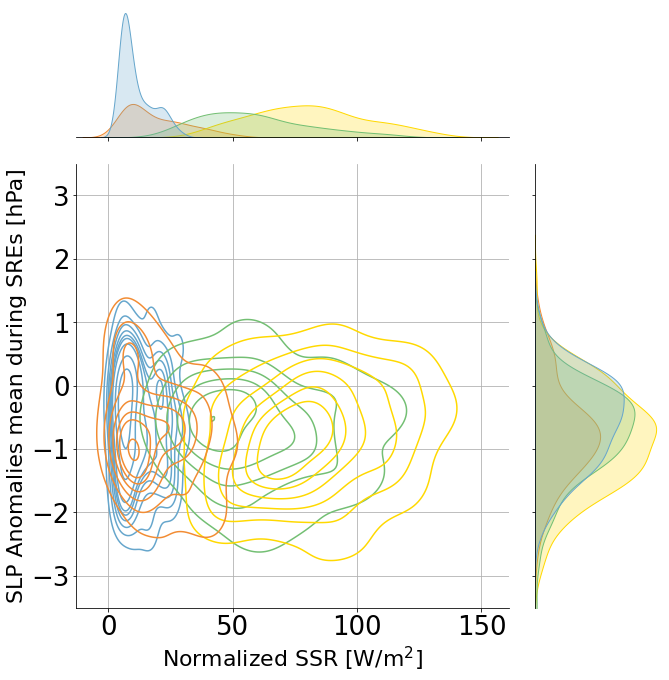

location = 'Moscow' and percentile = 90


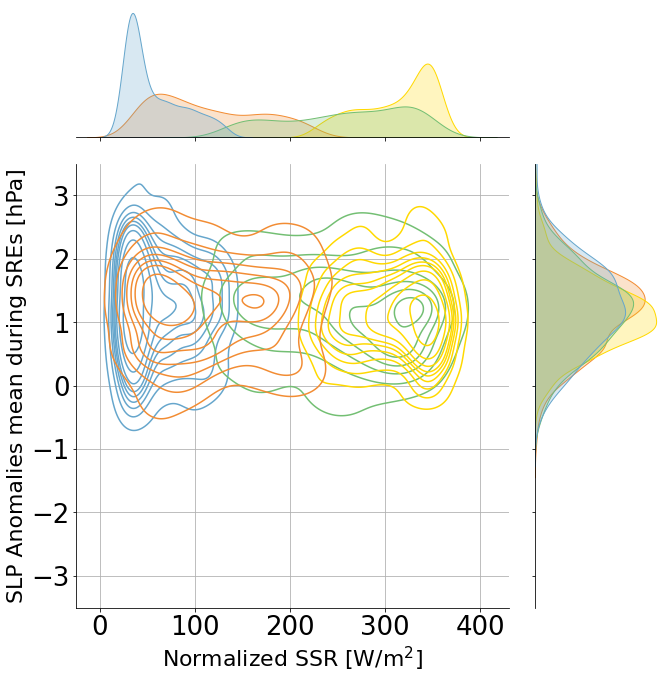

In [3]:
colors = np.array([ # Define colors associated with the different seasons
    [0.4, 0.65, 0.8],    # Winter: Sky Blue
    [0.45, 0.75, 0.45],  # Spring: Medium Green
    [1.0, 0.85, 0.0],    # Summer: Gold
    [0.95, 0.55, 0.2]    # Autumn: Dark Orange
])

for location in locations:

    data = {percentile: {} for percentile in [10, 90]}
    color_dict = {}  # Initialize your color dictionary

    for percentile in [10, 90]:

        print(f'{location = } and {percentile = }')

        for s, season in enumerate(seasons):

            indices = np.where(masks[season] == 1)[0] # Get all days that are within the season

            # Create a pandas data set to use in the jointplot
            data[percentile][season] = pd.DataFrame({
                'Seasons' : season,
                'psl': time_series_dict[location]['psl_waves_mean'][percentile][indices],
                'rsds': time_series_dict[location]['rsds_waves_mean'][percentile][indices]
            })

            color_dict[season] = colors[s]  # Add the color for the current season to your dictionary for the jointplot

        # Rearrange the data for the jointplot
        concatenated_data = pd.concat([data[percentile][season] for season in seasons], ignore_index=True)

        g = sns.jointplot(data=concatenated_data, x='rsds', y='psl', hue='Seasons', palette=color_dict, height=10, ratio=3, kind='kde', fill=True, shade=False)
        g.ax_joint.grid(True)

        g.ax_joint.set_ylim([-3.5, 3.5])  
        g.ax_joint.get_legend().remove()
        g.ax_joint.set_xlabel('Normalized SSR [W/m$^2$]', fontsize=22)
        g.ax_joint.set_ylabel('SLP Anomalies mean during SREs [hPa]', fontsize=22)

        plt.savefig(f'Figures/SLP/SLP_{location}_{percentile}.png', bbox_inches='tight')

        plt.show()